In [1]:
!pip install pyspark
!pip install chart_studio
from pyspark import SparkContext
from pyspark.sql import SQLContext, HiveContext, SparkSession
from pyspark.sql import functions as F
#import boto3
#from tcg_secret import *
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer, StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler, MinMaxScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType,ArrayType, DoubleType
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot, iplot
from matplotlib import rcParams
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import openpyxl.workbook
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from datetime import date

     |████████████████████████████████| 204.2MB 71kB/s 
     |████████████████████████████████| 204kB 50.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=807a3134c50af1d1be0f878b2612bd68f754fecf4950cdf5af13a596c14a5405
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
     |████████████████████████████████| 71kB 3.7MB/s 


In [2]:
ss = SparkSession.builder.appName("feat_eng").getOrCreate()
sqlContext = SQLContext(ss)
df = ss.read.format('csv').options(header='true').load('/content/sample_data/Online_Retail.csv', sep='|')

In [3]:
df.printSchema()
df.show(5, truncate = False)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANG

### Changing data type

In [4]:
df = df.withColumn('Quantity', F.col('Quantity').cast('integer'))
df = df.withColumn('UnitPrice', F.col('UnitPrice').cast('double'))

func = udf(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), DateType())
df = df.withColumn('InvoiceDate', func(col('InvoiceDate')))

In [5]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [6]:
df.describe().show()
df.toPandas().isnull().sum()

+-------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------+
|summary|        InvoiceNo|         StockCode|         Description|         Quantity|        UnitPrice|        CustomerID|    Country|
+-------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------+
|  count|           541909|            541909|              540454|           541909|           541909|            406829|     541909|
|   mean| 559965.752026781|27623.240210938104|                null| 9.55224954743324|4.611113626083086|15287.690570239585|       null|
| stddev|13428.41728080376|16799.737628427716|                null|218.0811578502348|96.75985306117958|   1713.6003033216|       null|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|           -80995|        -11062.06|             12346|  Australia|
|    max|          C581569|                 m|   wrongl

InvoiceNo           0
StockCode           0
Description      1455
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.agg(F.countDistinct(df.CustomerID)).show()
print('There"re', len(df.select('CustomerID').filter( df.CustomerID.isNotNull()).distinct().collect()), ' distinct customers.')

+-----------------+
|count(CustomerID)|
+-----------------+
|             4372|
+-----------------+

There"re 4372  distinct customers.


In [8]:
df.write.mode("overwrite").saveAsTable("sql_table1")

In [9]:
min_max_invoicedate = ss.sql('''
select min(InvoiceDate), max(invoiceDate) from sql_table1
''')
min_max_invoicedate.show()

+----------------+----------------+
|min(InvoiceDate)|max(invoiceDate)|
+----------------+----------------+
|      2010-12-01|      2011-12-09|
+----------------+----------------+



In [10]:
# Calculating total amount by customer & invoice level
invoice_totalamount = ss.sql('''
select Customerid, InvoiceNo, sum(quantity * unitprice) as TransTotalAmount from sql_table1 where customerid is not null group by customerid, invoiceno
''')

In [11]:
# Calculating average transaction spending for each customer
temp2 = invoice_totalamount.groupBy('CustomerID')\
.agg(
    F.countDistinct('InvoiceNo').alias('NumOfTrans2')
    ,F.sum('TransTotalAmount').alias('net_sales')
    )\
.withColumn('MeanTransSpend', F.col('net_sales')/F.col('NumOfTrans2')) 

In [12]:
print((temp2.count(), len(temp2.columns)))
temp2.limit(5).show()

(4372, 4)
+----------+-----------+------------------+-----------------+
|CustomerID|NumOfTrans2|         net_sales|   MeanTransSpend|
+----------+-----------+------------------+-----------------+
|     15555|         20|            4758.2|           237.91|
|     15574|          4|            702.25|         175.5625|
|     15634|          1|            243.55|           243.55|
|     13610|          9|1115.4300000000003|123.9366666666667|
|     13192|          2|            911.94|           455.97|
+----------+-----------+------------------+-----------------+



## Aggregating the Main Table

In [13]:
result = df.withColumn('TotalPrice', F.col('Quantity') * F.col('UnitPrice')) \
.filter(   (df.CustomerID.isNotNull()) &  (df.Description.isNotNull()) )\
.groupBy('CustomerID')\
.agg(
    F.max('InvoiceDate').alias('Last_Transaction_Date'),        
     F.max('UnitPrice').alias('MaxProductSpend'),                                                                                   
     F.sum('Quantity').alias('NumofProds'),                                        
     F.countDistinct('InvoiceNo').alias('NumofTrans'), 
     F.countDistinct('InvoiceDate').alias('Frequency'),                                            
     F.countDistinct('StockCode').alias('DistinctItems'),
     F.sum('TotalPrice').alias('TotalSpend')
     )\
.withColumn('DaysSinceTrans', (-1*F.datediff(F.col('Last_Transaction_Date'), \
F.to_date(F.lit(str('2011-12-31'))))).alias('diff'))\
.withColumn('MeanProductSpend', F.col('TotalSpend') / F.col('NumofProds'))

In [14]:
result.limit(5).show()
result.describe().show()

+----------+---------------------+---------------+----------+----------+---------+-------------+------------------+--------------+------------------+
|CustomerID|Last_Transaction_Date|MaxProductSpend|NumofProds|NumofTrans|Frequency|DistinctItems|        TotalSpend|DaysSinceTrans|  MeanProductSpend|
+----------+---------------------+---------------+----------+----------+---------+-------------+------------------+--------------+------------------+
|     15574|           2011-06-15|          14.95|       349|         4|        3|          131| 702.2500000000001|           199|2.0121776504297997|
|     17686|           2011-12-02|          16.95|      2478|         7|        5|          205| 5739.460000000005|            29|2.3161662631154174|
|     15555|           2011-11-27|          19.95|      4410|        20|       16|          404| 4758.199999999993|            34|1.0789569160997718|
|     13282|           2011-11-21|          14.95|       289|         6|        6|           30|    

In [15]:
# eliminating those customer with 2 countries
customer_country = ss.sql('''
select distinct Customerid, Country from sql_table1 
where customerid is not null and customerid in 
(select customerid from sql_table1 
group by customerid 
having count(distinct country) = 1)
''')
print((customer_country.count(), len(customer_country.columns)))

(4364, 2)


In [16]:
output = result.join(temp2, ['CustomerId'], 'left').join(customer_country, ['CustomerId'] ,'left')
print((output.count(), len(output.columns)))
output.limit(3).show()

(4372, 14)
+----------+---------------------+---------------+----------+----------+---------+-------------+-----------------+--------------+------------------+-----------+-----------------+-----------------+--------------+
|CustomerID|Last_Transaction_Date|MaxProductSpend|NumofProds|NumofTrans|Frequency|DistinctItems|       TotalSpend|DaysSinceTrans|  MeanProductSpend|NumOfTrans2|        net_sales|   MeanTransSpend|       Country|
+----------+---------------------+---------------+----------+----------+---------+-------------+-----------------+--------------+------------------+-----------+-----------------+-----------------+--------------+
|     15574|           2011-06-15|          14.95|       349|         4|        3|          131|702.2500000000001|           199|2.0121776504297997|          4|           702.25|         175.5625|United Kingdom|
|     17686|           2011-12-02|          16.95|      2478|         7|        5|          205|5739.460000000005|            29|2.3161662631

In [17]:
final = output.select(['CustomerID', 
 'Country',
 'Last_Transaction_Date',
 'MaxProductSpend',
 'NumofProds',
 'NumofTrans',
 'Frequency',
 'DistinctItems',
 'TotalSpend',
 'DaysSinceTrans',
 'MeanProductSpend',
 'MeanTransSpend'])

## Handling Outliers

In [18]:
col_outlier = ['MaxProductSpend','NumofProds','NumofTrans', 'Frequency','DistinctItems', 'TotalSpend', 'MeanProductSpend','MeanTransSpend'] 

In [19]:
col_outlier2 = []
for col in col_outlier:
    col_outlier2.append(col+'_RemovedOutliers')

In [20]:
outlier_stats2 = output.select(col_outlier).describe().collect()

In [21]:
# outlier_stats2

In [22]:
pd.DataFrame(outlier_stats2, columns = ['Calculation'] + col_outlier)

,Calculation,MaxProductSpend,NumofProds,NumofTrans,Frequency,DistinctItems,TotalSpend,MeanProductSpend,MeanTransSpend
0,count,4372,4372,4372,4372,4372,4372,4359,4372
1,mean,39.59115965233301,1122.3440073193046,5.07548032936871,4.413540713632205,61.21111619396157,1898.4597012808774,4.627256228047596,315.88340742424225
2,stddev,622.6613605746282,4672.790720294933,9.33875416357473,6.674343299080208,85.42511901387198,8219.345141066578,78.69660450697351,361.23730336260394
3,min,0.0,-303,1,1,1,-4287.63,-4.075,-4287.63
4,max,38970.0,196719,248,146,1794,279489.0199999992,4287.63,6207.669999999996


In [23]:
print(' mean: ',outlier_stats2[1]['MaxProductSpend']
      , '\n stddev: ',outlier_stats2[2]['MaxProductSpend']
      , '\n max: ',outlier_stats2[4]['MaxProductSpend'])

 mean:  39.59115965233301 
 stddev:  622.6613605746282 
 max:  38970.0


In [24]:
n_stddev = 4
for col in col_outlier:
    min_ = float(outlier_stats2[3][col])
    max_ = float(outlier_stats2[4][col])
    mean = float(outlier_stats2[1][col])
    stddev = float(outlier_stats2[2][col])
    max_limit = int(min(max_,mean + n_stddev*stddev))
    min_limit = int(max(min_,mean - n_stddev*stddev))
    print(col + '\n' +  'min: ' + str(min_) + ' , max: ' + str(max_))
    print('min_limit: ' + str(min_limit) + ' , max_limit: ' + str(max_limit) + '\n')

MaxProductSpend
min: 0.0 , max: 38970.0
min_limit: 0 , max_limit: 2530

NumofProds
min: -303.0 , max: 196719.0
min_limit: -303 , max_limit: 19813

NumofTrans
min: 1.0 , max: 248.0
min_limit: 1 , max_limit: 42

Frequency
min: 1.0 , max: 146.0
min_limit: 1 , max_limit: 31

DistinctItems
min: 1.0 , max: 1794.0
min_limit: 1 , max_limit: 402

TotalSpend
min: -4287.63 , max: 279489.0199999992
min_limit: -4287 , max_limit: 34775

MeanProductSpend
min: -4.075 , max: 4287.63
min_limit: -4 , max_limit: 319

MeanTransSpend
min: -4287.63 , max: 6207.669999999996
min_limit: -1129 , max_limit: 1760



In [25]:
n_stddev = 4
for col in col_outlier:
    min_ = float(outlier_stats2[3][col])
    max_ = float(outlier_stats2[4][col])
    mean = float(outlier_stats2[1][col])
    stddev = float(outlier_stats2[2][col])
    max_limit = min(max_,mean + n_stddev*stddev)
    min_limit = max(min_,mean - n_stddev*stddev)
    final = final.withColumn(col+ '_RemovedOutliers', F.when(F.col(col)>max_limit, max_limit)\
                             .when(F.col(col)<min_limit, min_limit)\
                             .otherwise(F.col(col))).drop(col)

In [26]:
final.limit(5).show()

+----------+--------------+---------------------+--------------+-------------------------------+--------------------------+--------------------------+-------------------------+-----------------------------+--------------------------+--------------------------------+------------------------------+
|CustomerID|       Country|Last_Transaction_Date|DaysSinceTrans|MaxProductSpend_RemovedOutliers|NumofProds_RemovedOutliers|NumofTrans_RemovedOutliers|Frequency_RemovedOutliers|DistinctItems_RemovedOutliers|TotalSpend_RemovedOutliers|MeanProductSpend_RemovedOutliers|MeanTransSpend_RemovedOutliers|
+----------+--------------+---------------------+--------------+-------------------------------+--------------------------+--------------------------+-------------------------+-----------------------------+--------------------------+--------------------------------+------------------------------+
|     15574|United Kingdom|           2011-06-15|           199|                          14.95|          

In [27]:
ID_cols = ['CustomerID']
cat_cols = ['Country']
non_cat_cols = ['MaxProductSpend_RemovedOutliers'
, 'NumofProds_RemovedOutliers'
, 'NumofTrans_RemovedOutliers'
, 'Frequency_RemovedOutliers'
, 'DistinctItems_RemovedOutliers'
, 'TotalSpend_RemovedOutliers'
, 'MeanProductSpend_RemovedOutliers'
, 'MeanTransSpend_RemovedOutliers']

In [28]:
column_string = ', '.join(ID_cols + cat_cols + non_cat_cols)
column_string

'CustomerID, Country, MaxProductSpend_RemovedOutliers, NumofProds_RemovedOutliers, NumofTrans_RemovedOutliers, Frequency_RemovedOutliers, DistinctItems_RemovedOutliers, TotalSpend_RemovedOutliers, MeanProductSpend_RemovedOutliers, MeanTransSpend_RemovedOutliers'

In [29]:
final.write.mode("overwrite").saveAsTable('member_add_features')

In [30]:
ss.sql('''
select * from member_add_features
''').limit(3).show()

+----------+--------------+---------------------+--------------+-------------------------------+--------------------------+--------------------------+-------------------------+-----------------------------+--------------------------+--------------------------------+------------------------------+
|CustomerID|       Country|Last_Transaction_Date|DaysSinceTrans|MaxProductSpend_RemovedOutliers|NumofProds_RemovedOutliers|NumofTrans_RemovedOutliers|Frequency_RemovedOutliers|DistinctItems_RemovedOutliers|TotalSpend_RemovedOutliers|MeanProductSpend_RemovedOutliers|MeanTransSpend_RemovedOutliers|
+----------+--------------+---------------------+--------------+-------------------------------+--------------------------+--------------------------+-------------------------+-----------------------------+--------------------------+--------------------------------+------------------------------+
|     15596|United Kingdom|           2011-08-31|           122|                          10.95|          

In [31]:
df_features_query = ('''
    SELECT {0}
    FROM member_add_features 
    where NumofProds_RemovedOutliers > 0 
    and TotalSpend_RemovedOutliers > 0 
    and MeanProductSpend_RemovedOutliers > 0 
    and MeanTransSpend_RemovedOutliers > 0''').format(column_string)

df_features = ss.sql(df_features_query)

In [32]:
df_features.toPandas().isnull().sum()

CustomerID                          0
Country                             8
MaxProductSpend_RemovedOutliers     0
NumofProds_RemovedOutliers          0
NumofTrans_RemovedOutliers          0
Frequency_RemovedOutliers           0
DistinctItems_RemovedOutliers       0
TotalSpend_RemovedOutliers          0
MeanProductSpend_RemovedOutliers    0
MeanTransSpend_RemovedOutliers      0
dtype: int64

In [33]:
df_features = df_features.withColumn('Country'                            ,
    F.when(df_features['Country'].isNull(),'Unknown').
    otherwise(df_features['Country']))

In [34]:
df_features.toPandas().isnull().sum()

CustomerID                          0
Country                             0
MaxProductSpend_RemovedOutliers     0
NumofProds_RemovedOutliers          0
NumofTrans_RemovedOutliers          0
Frequency_RemovedOutliers           0
DistinctItems_RemovedOutliers       0
TotalSpend_RemovedOutliers          0
MeanProductSpend_RemovedOutliers    0
MeanTransSpend_RemovedOutliers      0
dtype: int64

## After Data preprocessing (step 35 - 51), we apply Elbow Method to select the k value

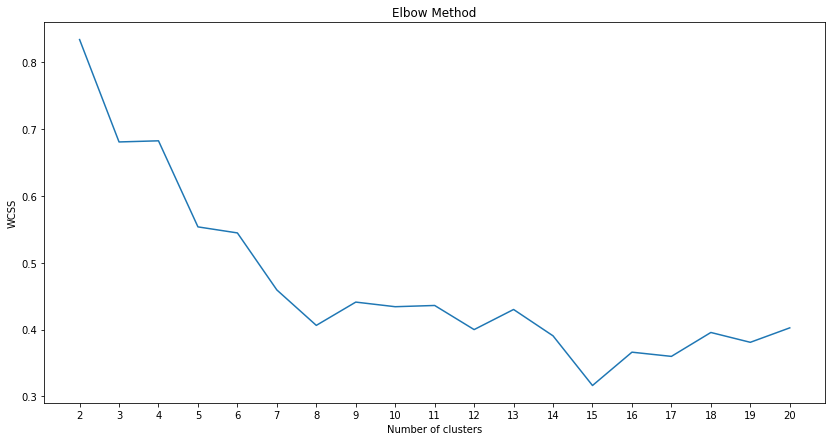

In [52]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7
plt.plot(k, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
xi = list(k)
plt.xticks(xi)
plt.show()

In [53]:
## We select the number of clusters where the change in WCSS begins to level off, let's pick 8.

In [54]:
k = 8
for i in range(1,6):
    kmeanstest = KMeans(featuresCol='features', k=k, maxIter=1000, tol=1e-4).setSeed(i)
    model_test = kmeanstest.fit(data)
    best_results = model_test.transform(data)
    best_results.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  750|
|         1|   36|
|         2|    2|
|         3|  118|
|         4|  196|
|         5|  769|
|         6| 2292|
|         7|  152|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   32|
|         1| 2545|
|         2|  240|
|         3|   13|
|         4|    2|
|         5|  365|
|         6|  112|
|         7| 1006|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   32|
|         1| 2347|
|         2|  165|
|         3|  142|
|         4|    2|
|         5|   13|
|         6|  749|
|         7|  865|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  733|
|         1| 2367|
|         2|    5|
|         3|  870|
|         4|   31|
|         5|  153|
|         6|  143|
|         7|   13|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  996|
|       

In [55]:
seed = 4

kmeans2 = KMeans(featuresCol='features', k=k, maxIter=1000, tol=1e-4).setSeed(seed)
model2 = kmeans2.fit(data)
results = model2.transform(data)
results.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  733|
|         1| 2367|
|         2|    5|
|         3|  870|
|         4|   31|
|         5|  153|
|         6|  143|
|         7|   13|
+----------+-----+



In [56]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(results)
print(model_pca.explainedVariance)

results_pca = model_pca.transform(results)

vector_udf = F.udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))

results_df = results_pca.withColumn('PCA', vector_udf('pcaFeatures'))\
                         .withColumn('PCA_1', F.col('PCA')[0])\
                         .withColumn('PCA_2', F.col('PCA')[1])\
                         .withColumn('PCA_3', F.col('PCA')[2])

[0.49310846654852153,0.15110039805192443,0.1272036779007646]


In [57]:
sum(model_pca.explainedVariance)

0.7714125425012106

In [58]:
results_df.limit(3).toPandas()

,CustomerID,features,prediction,pcaFeatures,PCA,PCA_1,PCA_2,PCA_3
0,15596,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.38937587324363415, 0.7677204388175582, 0.87...","[0.38937587324363415, 0.7677204388175582, 0.87...",0.389376,0.767720,0.873811
1,12377,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",3,"[0.0267845758287798, -1.0987251997106355, -1.5...","[0.0267845758287798, -1.0987251997106355, -1.5...",0.026785,-1.098725,-1.524575
2,17867,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[-0.18925050978975536, 0.7079961016743717, 0.8...","[-0.18925050978975536, 0.7079961016743717, 0.8...",-0.189251,0.707996,0.888726


In [59]:
cust_cluster_df = results_df.withColumn('ClusterID', F.col('prediction')+1)\
                               .drop('prediction')

In [60]:
df_outcome = cust_cluster_df.select('CustomerID','ClusterID','PCA_1','PCA_2','PCA_3').toPandas()

In [61]:
df_outcome = df_outcome.sort_values(by = 'ClusterID')
df_outcome.head()
df_outcome.CustomerID.nunique()
df_outcome.ClusterID.value_counts()#.to_csv('Cluster_size.csv')

2    2367
4     870
1     733
6     153
7     143
5      31
8      13
3       5
Name: ClusterID, dtype: int64